# EDA

The first step in any Data Science project is to perform an Exploratory Data Analysis, to get a grasp on how the data looks and how it behaves. By doing this you can see any outliers, wrong or empty values and thus make decisions on how to prepare the data to make predictions.

## Price EDA

First, it is important to understand how each variable is distributed across the dataset, also, the target variable will be 'close' which is the closing price of the stock at the end of the trading day, so by graphing this variable for each stock we can get an idea on how it behaves

In [49]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [50]:
# read the data
price = pd.read_csv('price.csv')
# descriptive statistics
price.describe()

,open,high,low,close,volume
count,1687.000000,1687.000000,1687.000000,1687.000000,1.687000e+03
mean,245.203879,248.029241,242.278194,245.264770,9.613876e+07
std,134.583166,135.776406,133.247946,134.540129,1.442287e+08
min,45.466000,46.077000,45.009998,45.502998,5.467500e+06
25%,158.190002,160.525002,156.540001,159.059998,2.076580e+07
50%,187.360001,189.279999,185.419998,187.429993,3.934310e+07
75%,371.489990,374.440002,368.845001,372.860001,8.306055e+07
max,598.219971,602.950012,589.960022,595.940002,1.142269e+09


In [51]:
# check null values
price.isnull().sum()

date      0
ticker    0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

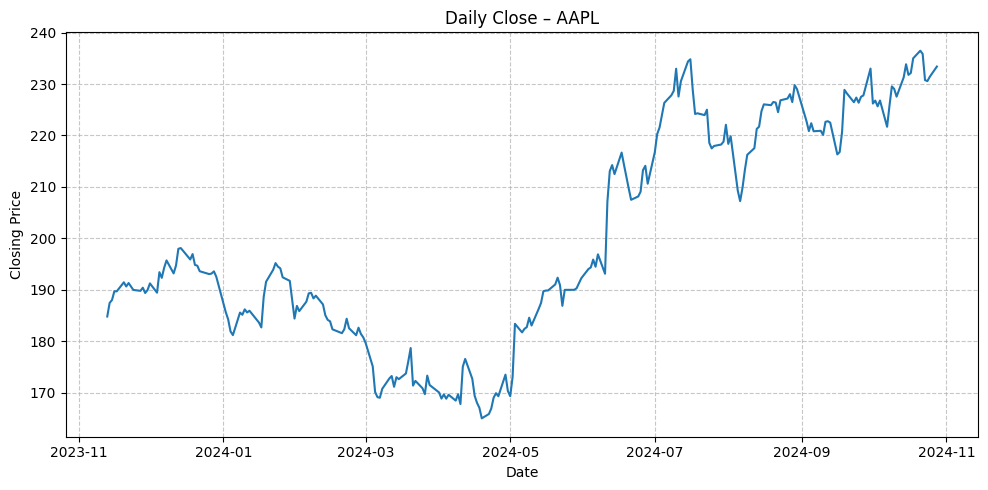

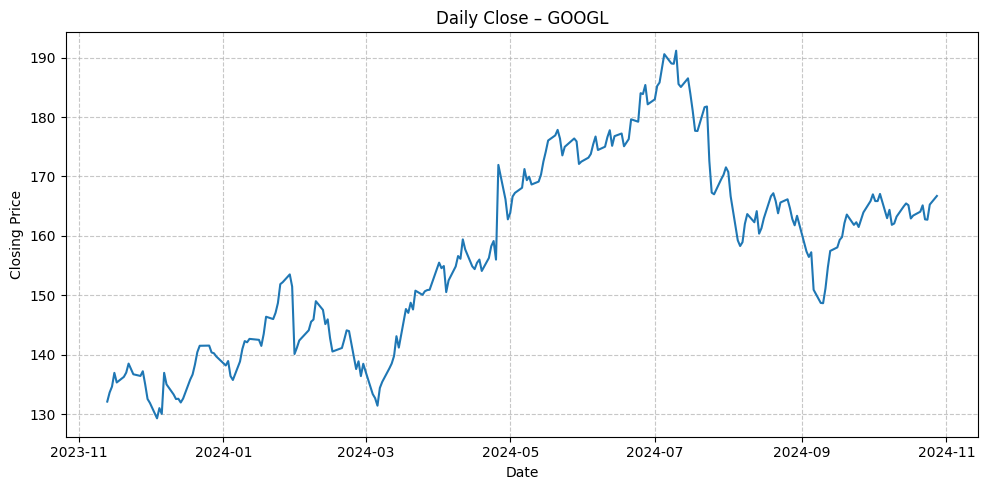

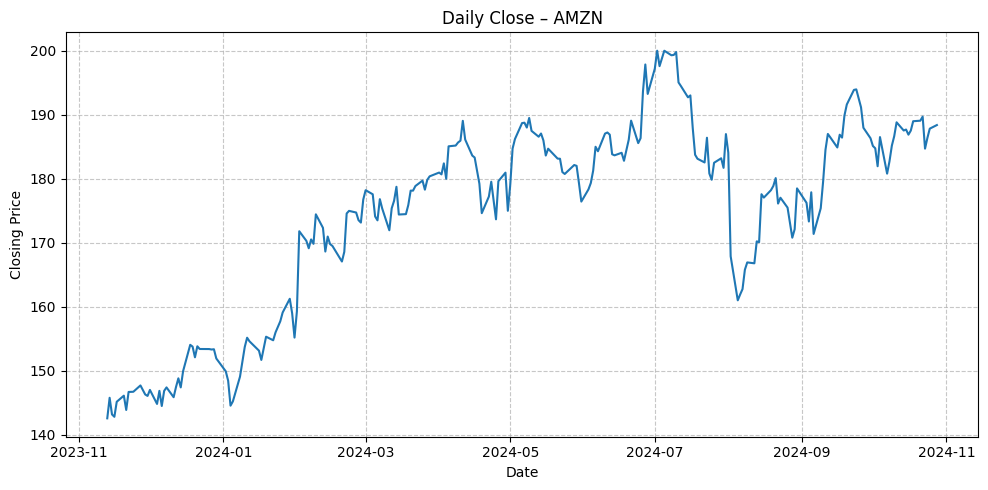

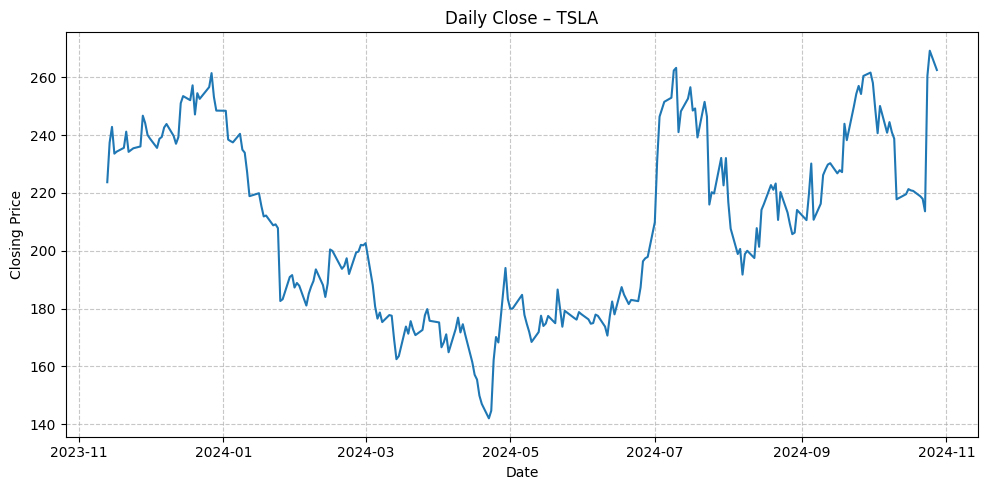

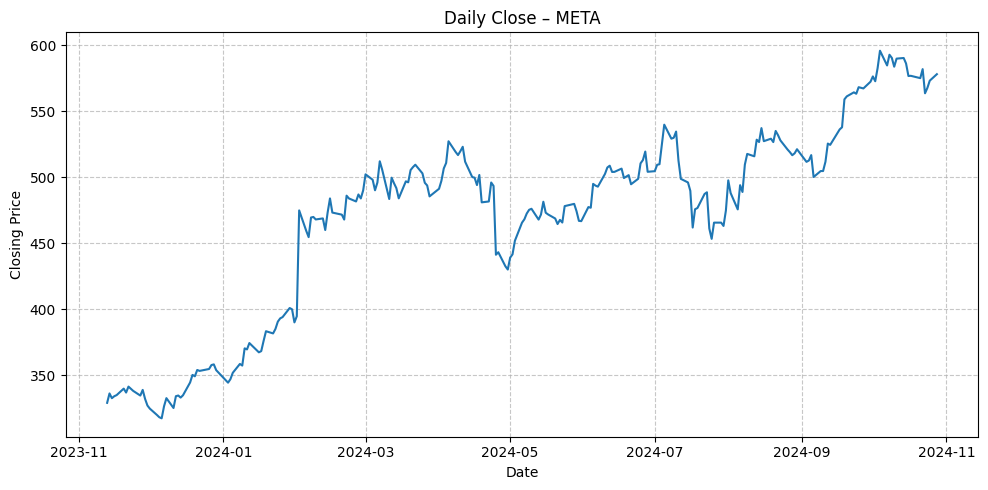

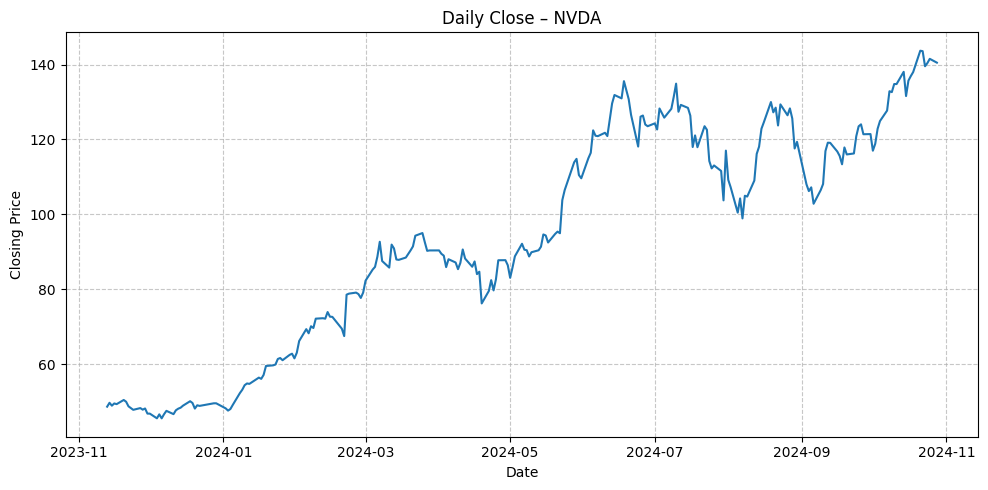

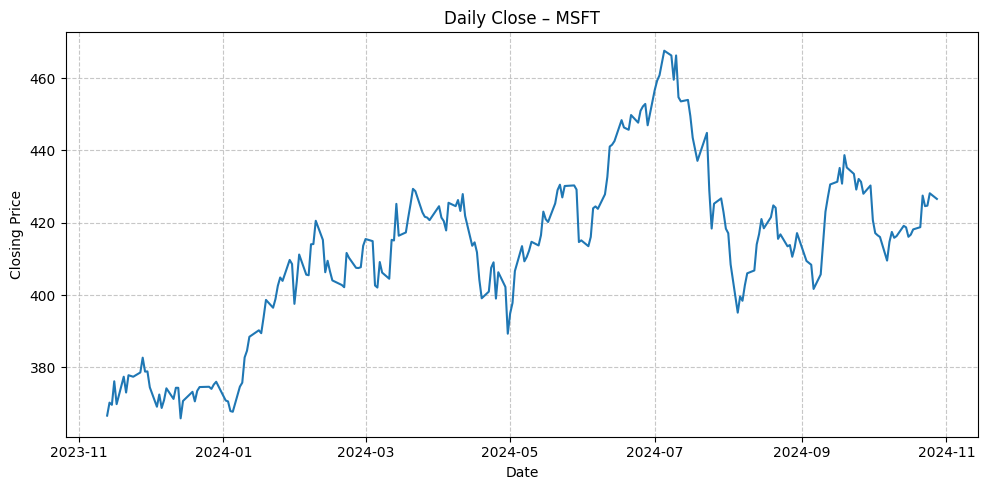

In [52]:
# plot the closing price for each stock
price["date"] = pd.to_datetime(price["date"])
for ticker in price["ticker"].unique():
    ticker_data = price[price["ticker"] == ticker].sort_values("date")
    
    plt.figure(figsize=(10, 5))
    plt.plot(ticker_data["date"], ticker_data["close"])
    plt.title(f"Daily Close – {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.tight_layout()
    plt.show()

By doing this simple exploration, the data appears to be clean and without any clear outliers or wrong values, also, thanks to the graphs above we can see that the closing prices behave as expected, without any outliers, meaning the data is pretty clean

## News EDA

This dataset is simple, contains the ticker and a news related to it, there can be multiple news on one single day, and the content of these news can impact directly on the closing price on the stock

In [53]:
# read the news data
news = pd.read_csv('news.csv')
news.head()

,datetime,ticker,headline,summary
0,2024-10-29 18:07:48,AAPL,Apple Unveils the Redesigned Mac Mini,-- Apple overhauled the design of its Mac mini...
1,2024-10-29 02:21:10,AAPL,Apple blocked from selling iPhone 16 in Indone...,TECH giant Apple will not be allowed to sell i...
2,2024-10-28 14:05:22,AAPL,"Apple Rises on Apple Intelligence Rollout, New...",-- Apple unveiled its new iMac and said Apple ...
3,2024-10-28 12:05:04,AAPL,Apple : How Apple developed the world’s first ...,apple stories Inside the Audio Lab: How Apple ...
4,2024-10-28 11:02:06,AAPL,Apple launches the iPhone into the AI era with...,Apple is releasing a free software update that...


In [54]:
# check for null values 
news.isnull().sum()

datetime    0
ticker      0
headline    0
summary     1
dtype: int64

In [55]:
# Summarize news data
news["datetime"] = pd.to_datetime(news["datetime"], errors="coerce")
news["day"] = news["datetime"].dt.floor("D")

summary = (
    news.groupby("ticker")
        .agg(
            total_news=("datetime", "count"),
            days_with_news=("day", "nunique"),
            first_day=("day", "min"),
            last_day=("day", "max"),
        )
        .reset_index()
)
# Calculate average news per day
summary["avg_news_per_day"] = summary["total_news"] / summary["days_with_news"]
summary = (
    summary[["ticker", "total_news", "days_with_news", "avg_news_per_day"]]
    .sort_values("total_news", ascending=False)
    .reset_index(drop=True)
    .round(3)
)

print(summary)


  ticker  total_news  days_with_news  avg_news_per_day
0   AMZN         941             238             3.954
1   AAPL         799             224             3.567
2   TSLA         794             225             3.529
3   NVDA         594             173             3.434
4   MSFT         535             193             2.772
5   META         391             179             2.184
6  GOOGL         386             155             2.490


# Preprocessing & feature engineering

Here the data will be prepared to train an ML model in order to make predictions for the closing price. First the news will be passed through a sentiment analysis model (Vader) to determine if the summary is positive or negative, as the type of news should be a big factor in determining the closing price.  Vader (Valence Aware Dictionary and sEntiment Reasoner) uses a lexicon of words with pre-assigned sentiment scores, applies rules for punctuation, capitalization, degree modifiers, and negations, then combines them to produce positive, negative, neutral, and compound sentiment scores for text. Since one stock can have multiple news on the same day the features related to the news will be:

- Average sentiment
- Minimum sentiment
- Maximum sentiment
- News count

In case one day did not have any news associated to that stock everything will be set to 0

Finally, the price and sentiment datasets will be merged

In [69]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

price["day"]    = price["date"].dt.floor("D")
news["datetime"] = pd.to_datetime(news["datetime"], errors="coerce")
news["day"]      = news["datetime"].dt.floor("D")

analyzer = SentimentIntensityAnalyzer()
news["summary"]   = news["summary"].fillna("").astype(str)
news["sentiment"] = news["summary"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

sentiment_daily = (
    news.groupby(["ticker", "day"], as_index=False)
        .agg(
            avg_sentiment=("sentiment", "mean"),
            min_sentiment=("sentiment", "min"),
            max_sentiment=("sentiment", "max"),
            news_count=("sentiment", "count")
        )
)


all_days = (
    price[["ticker", "day"]]
    .dropna()
    .drop_duplicates()
    .sort_values(["ticker", "day"])
    .reset_index(drop=True)
)

sentiment_df = all_days.merge(sentiment_daily, on=["ticker", "day"], how="left")
sentiment_df["avg_sentiment"] = sentiment_df["avg_sentiment"].fillna(0.0)
sentiment_df["min_sentiment"] = sentiment_df["min_sentiment"].fillna(0.0)
sentiment_df["max_sentiment"] = sentiment_df["max_sentiment"].fillna(0.0)
sentiment_df["news_count"]    = sentiment_df["news_count"].fillna(0).astype(int)
sentiment_df.head()


,ticker,day,avg_sentiment,min_sentiment,max_sentiment,news_count
0,AAPL,2023-11-13,0.025800,0.0258,0.0258,1
1,AAPL,2023-11-14,0.784500,0.7845,0.7845,1
2,AAPL,2023-11-15,0.000000,0.0000,0.0000,0
3,AAPL,2023-11-16,0.169033,-0.3254,0.6705,6
4,AAPL,2023-11-17,0.275367,0.2023,0.4215,3


In [59]:
sent_cols = ["ticker", "day", "avg_sentiment", "min_sentiment", "max_sentiment", "news_count"]
sentiment_df = sentiment_df[sent_cols]
final_df = price.merge(sentiment_df, on=["ticker", "day"], how="left")
final_df.drop('day',axis=1, inplace=True)
final_df.head()

,date,ticker,open,high,low,close,volume,avg_sentiment,min_sentiment,max_sentiment,news_count
0,2023-11-13,AAPL,185.820007,186.029999,184.210007,184.800003,43627500,0.025800,0.0258,0.0258,1
1,2023-11-14,AAPL,187.699997,188.110001,186.300003,187.440002,60108400,0.784500,0.7845,0.7845,1
2,2023-11-15,AAPL,187.850006,189.500000,187.779999,188.009995,53790500,0.000000,0.0000,0.0000,0
3,2023-11-16,AAPL,189.570007,190.960007,188.649994,189.710007,54412900,0.169033,-0.3254,0.6705,6
4,2023-11-17,AAPL,190.250000,190.380005,188.570007,189.690002,50922700,0.275367,0.2023,0.4215,3


# Modeling and Results

Now with the data prepared, we can start  trying multiple ML models to predict the closing price of each stock the day after ($t+1$). The data will be split in two sets, one for training which will be the first 192 days, and one for testing, the last 48 days. 3 different models will be compared:

1. Gradient Boosting: this model is builed in stages where each new tree corrects the errors of the previous ones.
2. Random Forest: this model builds many decision trees in parallel on random subsets of data and features, then averages their predictions.
3. XGBoost: this model is an regularized version of Gradien Boosting for faster training and better generalization

The 3 models will be judged based on:

- MAE: Mean Absolute Error
- RMSE: Root Mean Squared Error
- MAPE: Mean Average Percentage Error

In [67]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare the data for modeling
df = final_df.copy()
df = df.sort_values(["ticker", "date"])
df["close_next"] = df.groupby("ticker")["close"].shift(-1)
df = df.dropna(subset=["close_next"]).copy()

# Features used to predict the closing price
feature_cols = ["close", "open", "high", "low", "volume",
                "avg_sentiment", "min_sentiment", "max_sentiment", "news_count"]
feature_cols = [c for c in feature_cols if c in df.columns]

# Define metrics functions
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def metrics_dict(y_true, y_pred, model_name, tkr):
    return {
        "ticker": tkr,
        "model": model_name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAPE_%": mape(y_true, y_pred),
    }

# Define models to train
models = {
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "RandomForest":     RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "XGBoost":          XGBRegressor(random_state=42, n_estimators=400, learning_rate=0.05, max_depth=6, n_jobs=-1),
}

# List to store results and predictions
results = []
pred_rows = []

# Iterate over each ticker and train models
for tkr, g in df.groupby("ticker", sort=False):
    g = g.sort_values("date")
    # Divide the data into training and testing sets (80% train, 20% test)
    split_idx = int(len(g) * 0.8)
    train = g.iloc[:split_idx]
    test  = g.iloc[split_idx:]
    X_train, y_train = train[feature_cols], train["close_next"]
    X_test,  y_test  = test[feature_cols],  test["close_next"]

    # Train each model and evaluate
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Append metrics
        results.append(metrics_dict(y_test, y_pred, name, tkr))

        # Save predictions for plotting later
        tmp = test[["ticker", "date"]].copy()
        tmp["model"] = name
        tmp["actual_next_close"] = y_test.values
        tmp["pred_next_close"]   = y_pred
        pred_rows.append(tmp)

# Metrics DataFrame
results_df = pd.DataFrame(results).sort_values(["ticker", "RMSE"])
print(results_df)

# Data frame to compare predictions with actual values
preds_df = pd.concat(pred_rows, ignore_index=True)
preds_df["date"] = pd.to_datetime(preds_df["date"])

   ticker             model        MAE       RMSE    MAPE_%
1    AAPL      RandomForest   2.428093   3.166135  1.066767
0    AAPL  GradientBoosting   2.658952   3.400075  1.171864
2    AAPL           XGBoost   2.962701   3.616141  1.305341
4    AMZN      RandomForest   2.341867   2.865798  1.283928
3    AMZN  GradientBoosting   2.476948   2.927237  1.355124
5    AMZN           XGBoost   2.787780   3.389642  1.516363
7   GOOGL      RandomForest   1.839784   2.519706  1.147812
8   GOOGL           XGBoost   2.052399   2.623262  1.279304
6   GOOGL  GradientBoosting   2.159432   2.893296  1.351087
10   META      RandomForest  33.701876  41.004381  5.892656
9    META  GradientBoosting  34.894054  42.719060  6.097103
11   META           XGBoost  37.719614  45.818777  6.596555
14   MSFT           XGBoost   4.851629   5.590270  1.152791
13   MSFT      RandomForest   5.056618   5.704469  1.200905
12   MSFT  GradientBoosting   5.045116   5.859141  1.198477
16   NVDA      RandomForest   4.998938  

Judging by the results above, it appears that the best performing model is Random Forest Regressor, as it outperforms the other ones in, MAE, RMSE and MAPE on each stock, we will plot the results of each one of these using Random Forest to understand the results better

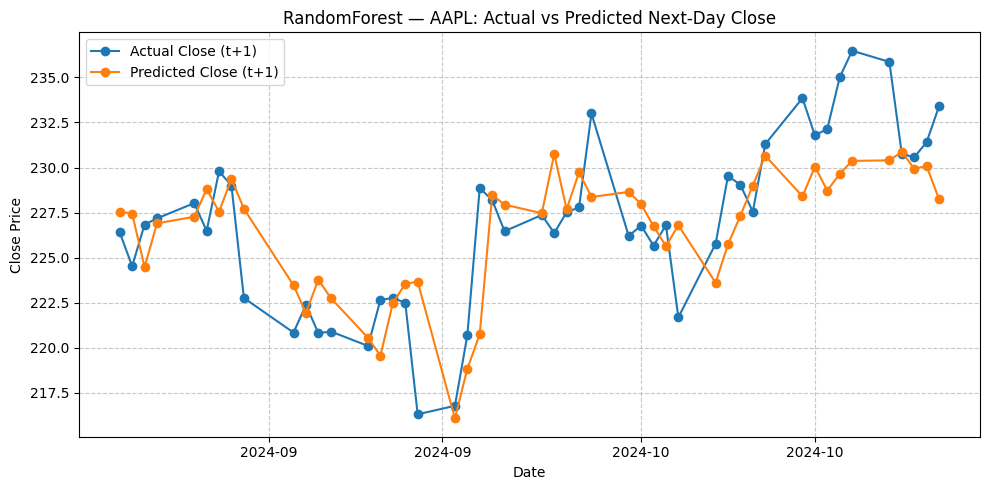

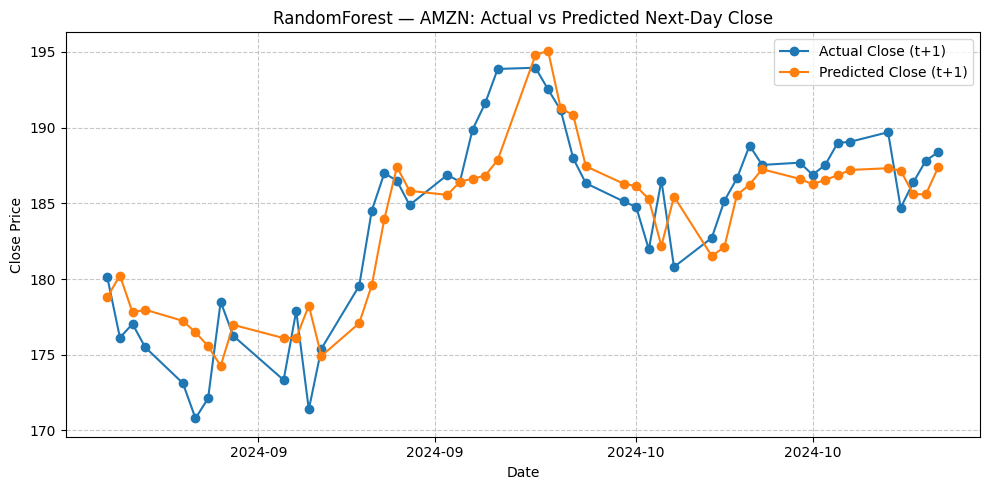

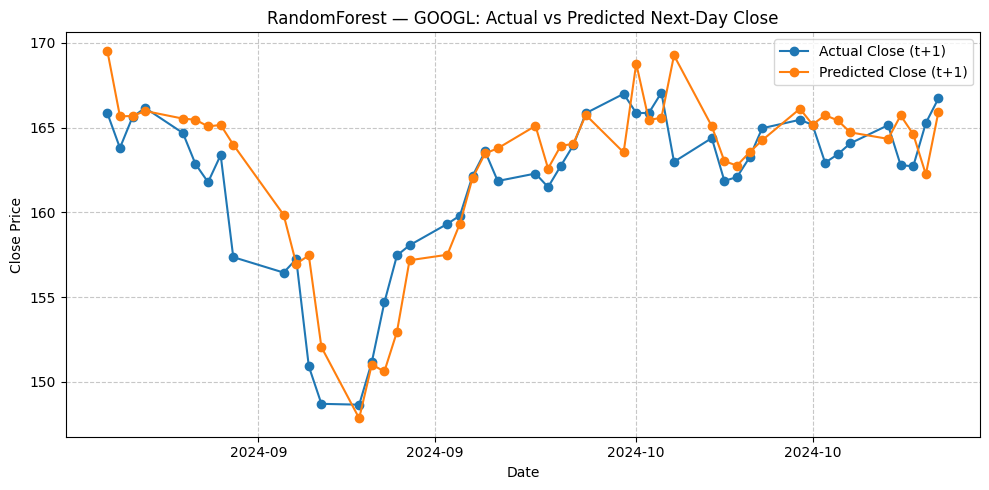

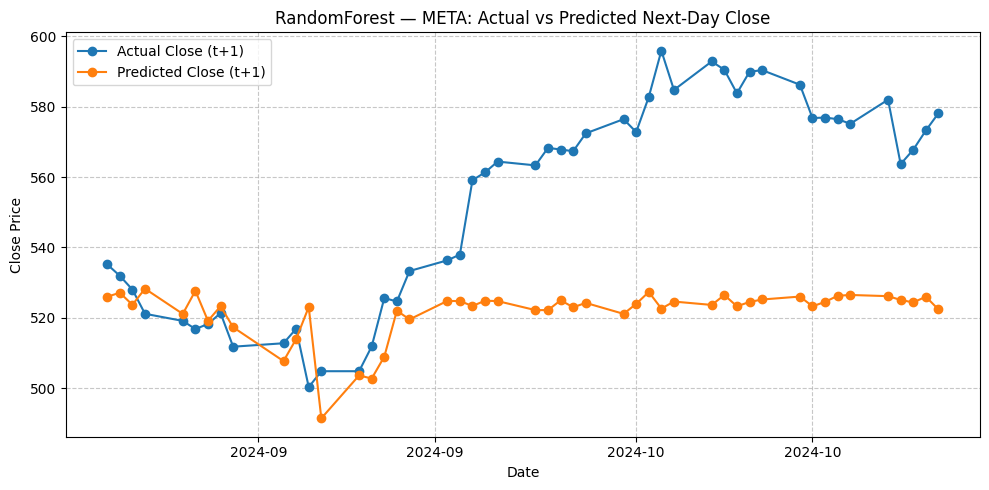

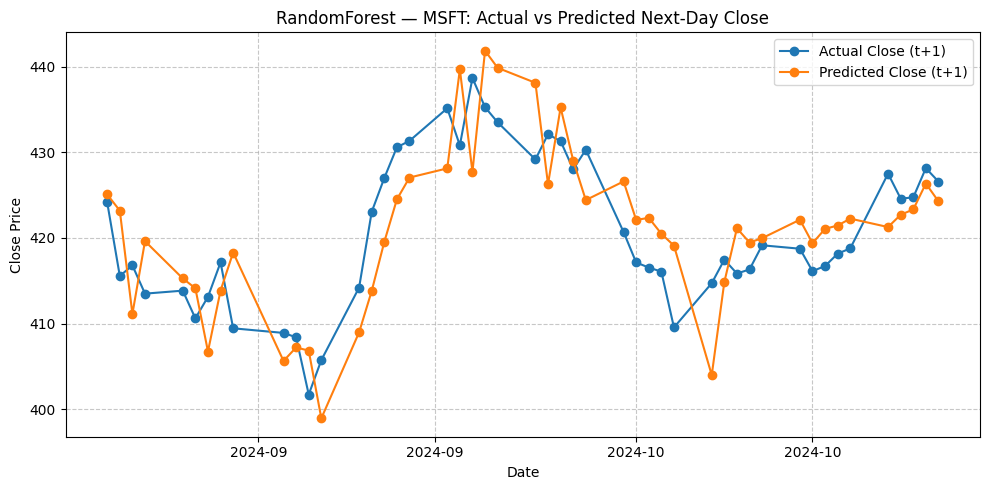

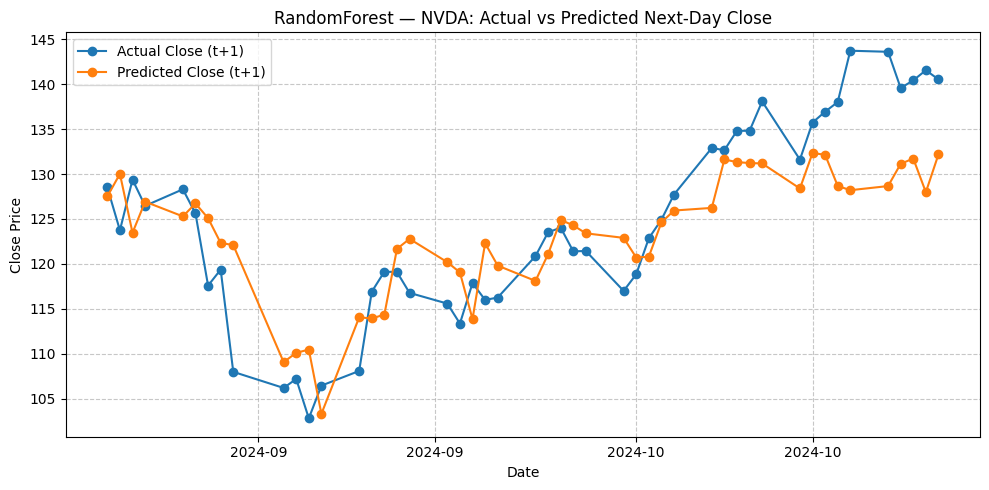

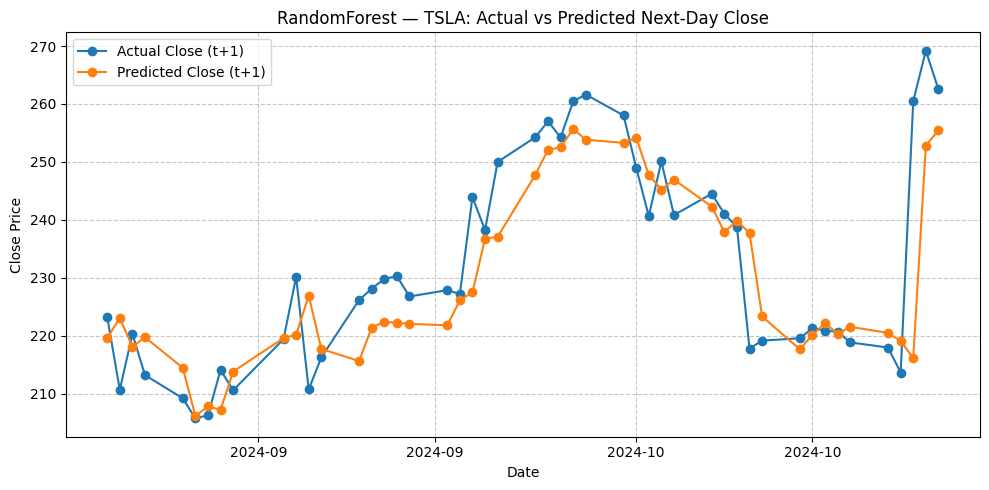

In [68]:
# Separate and plot results for RandomForest model
rf_df = preds_df[preds_df["model"] == "RandomForest"].copy()
rf_df["date"] = pd.to_datetime(rf_df["date"])

for tkr, g in rf_df.groupby("ticker"):
    plot_df = g.sort_values("date")

    plt.figure(figsize=(10, 5))
    plt.plot(plot_df["date"], plot_df["actual_next_close"], label="Actual Close (t+1)", marker="o", linewidth=1.5)
    plt.plot(plot_df["date"], plot_df["pred_next_close"],   label="Predicted Close (t+1)", marker="o", linewidth=1.5)

    plt.title(f"RandomForest — {tkr}: Actual vs Predicted Next-Day Close")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.tight_layout()
    plt.legend()
    plt.show()

# Conclusion